In [ ]:
# Install the required Hugging Face libraries
!pip install -q transformers datasets

# Import pandas for handling and processing tabular data
import pandas as pd

# Import numpy for numerical operations (like working with arrays)
import numpy as np

# Import matplotlib for plotting graphs and visualizations
import matplotlib.pyplot as plt

# Import train_test_split to split your dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Import the T5 tokenizer and model for text-to-text generation tasks (like summarization)
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments

# Import Hugging Face Dataset class for handling datasets in a standardized way
from datasets import Dataset

# Import torch (PyTorch) which is the backend deep learning library used for training the model
import torch


In [ ]:
df_train = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')
df_test = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv')

# Previewing
df_train.head()


,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
#Pre-processing:
# Total missing values in the entire DataFrame
total_missing = df_train.isnull().sum().sum()
print(f"Total missing values: {total_missing}")

# Missing values per column (optional breakdown)
print("\nMissing values per column:")
print(df_train.isnull().sum())


Total missing values: 0

Missing values per column:
id            0
article       0
highlights    0
dtype: int64


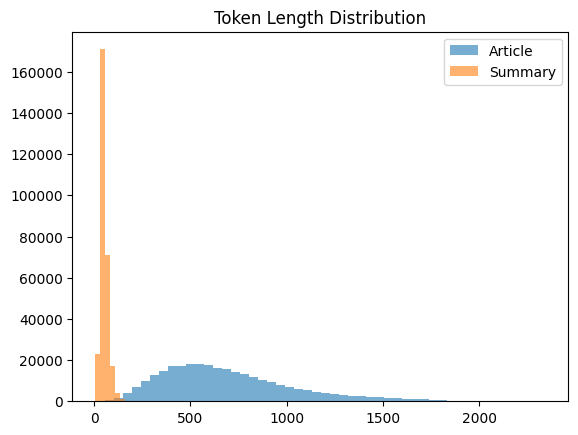

In [ ]:
article_lengths = df_train['article'].apply(lambda x: len(x.split()))
summary_lengths = df_train['highlights'].apply(lambda x: len(x.split()))
plt.hist(article_lengths, bins=50, alpha=0.6, label='Article')
plt.hist(summary_lengths, bins=50, alpha=0.6, label='Summary')
plt.legend()
plt.title("Token Length Distribution")
plt.show()

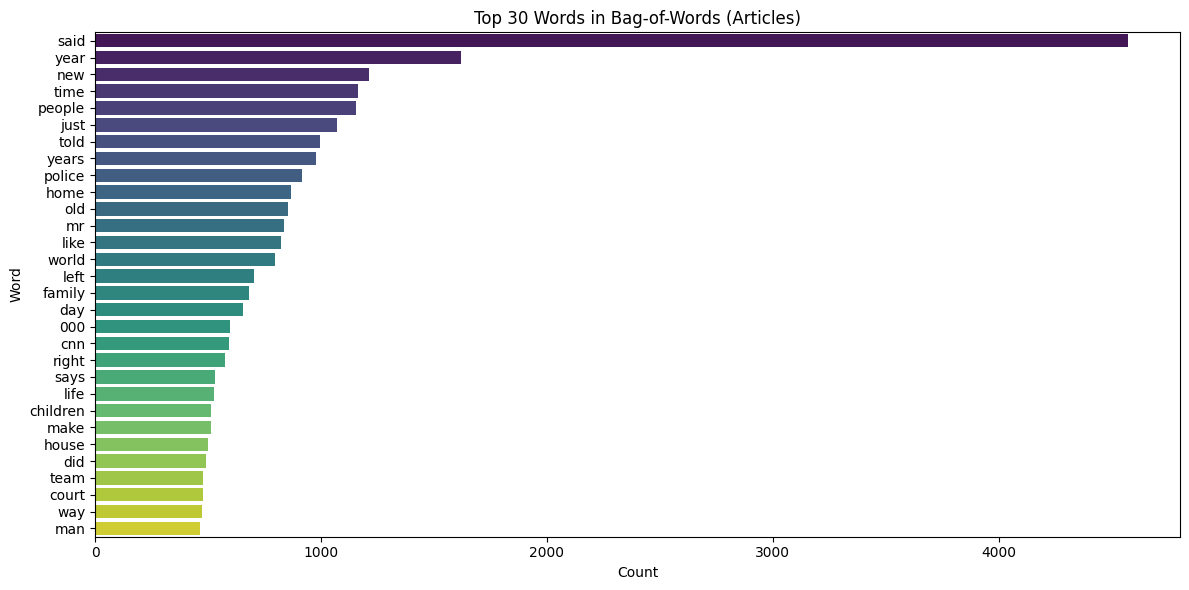

In [ ]:
# Import CountVectorizer to convert text data into a bag-of-words (BoW) representation
from sklearn.feature_extraction.text import CountVectorizer

# Import matplotlib for plotting and seaborn for prettier statistical visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Take a random sample of 1000 article texts from the training dataset to speed up processing
text_sample = df_train['article'].sample(1000).tolist()

# Initialize the CountVectorizer:
# stop_words='english' removes common words like "the", "and", etc.
# max_features=30 keeps only the top 30 most frequent words
vectorizer = CountVectorizer(stop_words='english', max_features=30)

# Fit the vectorizer on the sample and transform the text into a sparse matrix of word counts
X = vectorizer.fit_transform(text_sample)

# Convert the sparse matrix to an array and sum word counts across all documents (axis=0)
word_counts = X.toarray().sum(axis=0)

# Get the list of words corresponding to the columns of the BoW matrix
words = vectorizer.get_feature_names_out()

# Create a DataFrame to store each word and its total count
bow_df = pd.DataFrame({'word': words, 'count': word_counts})

# Sort the DataFrame so the most frequent words come first
bow_df = bow_df.sort_values(by='count', ascending=False)

# Create a bar plot showing the top 30 words by frequency
plt.figure(figsize=(12,6))  # Set the size of the plot
sns.barplot(x='count', y='word', data=bow_df, palette='viridis')  # Use seaborn's barplot
plt.title('Top 30 Words in Bag-of-Words (Articles)')  # Title of the plot
plt.xlabel('Count')  # Label for x-axis
plt.ylabel('Word')   # Label for y-axis
plt.tight_layout()   # Adjust layout to prevent overlap
plt.show()           # Display the plot



In [ ]:
# Load the tokenizer for the 't5-small' model
# The tokenizer is responsible for converting raw text into tokens that the model can understand
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Set the maximum length for input text (e.g., articles) to 512 tokens
# This ensures that the model doesn't process overly long texts, which could lead to memory issues
max_input_len = 512

# Set the maximum length for target text (e.g., summaries) to 128 tokens
# This helps control the output length of the generated summary
max_target_len = 128


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
# Define a function to tokenize a batch of examples from the dataset
def tokenize(batch):
    # Prefix each article with "summarize: " as required by T5 format
    # T5 uses task-specific prefixes to guide the model on what task to perform
    inputs = ["summarize: " + doc for doc in batch['article']]

    # Tokenize the input texts (articles)
    #  max_length ensures all sequences are no longer than 512 tokens
    #  truncation shortens sequences longer than max_length
    #  padding="max_length" adds padding so all sequences are of equal length
    model_inputs = tokenizer(inputs, max_length=max_input_len, truncation=True, padding="max_length")

    # Tokenize the target texts (summaries/highlights)
    # This is done inside a special block to ensure the tokenizer knows we're encoding targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['highlights'], max_length=max_target_len, truncation=True, padding="max_length")

    # Add the tokenized target sequences (labels) to the model inputs
    model_inputs['labels'] = labels['input_ids']

    # Return the complete dictionary containing tokenized inputs and labels
    return model_inputs


In [ ]:
print(f"Number of training samples: {len(df_train)}")
print(f"Number of testing samples: {len(df_test)}")


Number of training samples: 287113
Number of testing samples: 287113


In [ ]:
# Converting to HuggingFace Dataset
dataset_train = Dataset.from_pandas(df_train.sample(7000))
dataset_test = Dataset.from_pandas(df_test.sample(2000))

tokenized_train = dataset_train.map(tokenize, batched=True, remove_columns=['article', 'highlights'])
tokenized_test = dataset_test.map(tokenize, batched=True, remove_columns=['article', 'highlights'])

Map:   0%|          | 0/7000 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
# Load the pre-trained T5-small model for conditional text generation
# This model is capable of performing tasks like summarization, translation, and question answering
model = T5ForConditionalGeneration.from_pretrained('t5-small')


In [ ]:
pip install --upgrade transformers


In [ ]:
# Import PyTorch for hardware checks and tensor computations
import torch

# Check if CUDA (GPU acceleration) is available
print(f"CUDA available: {torch.cuda.is_available()}")

# Print how many GPUs are available (usually 1 in Kaggle/Colab, or more if on a workstation)
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Set the device to GPU if available, otherwise fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the T5-small model again and move it to the appropriate device (GPU/CPU)
# Note: Ensure 'model_name' is defined earlier as 't5-small'
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Define training arguments for the Hugging Face Trainer API
training_args = TrainingArguments(
    output_dir="t5_summarizer",            # Folder to save model checkpoints
    num_train_epochs=2,                    # Number of passes over the training data
    per_device_train_batch_size=4,         # Training batch size per GPU/CPU
    per_device_eval_batch_size=4,          # Evaluation batch size per GPU/CPU
    warmup_steps=100,                      # Number of warm-up steps for learning rate scheduler
    weight_decay=0.01,                     # Apply weight decay (regularization) to reduce overfitting
    logging_dir="logs",                    # Where to store logs
    logging_steps=50,                      # Log training info every 50 steps
    save_total_limit=2,                    # Keep only the 2 most recent model checkpoints
    load_best_model_at_end=True,           # Load the best checkpoint at the end based on evaluation loss
    eval_strategy="epoch",                 # Run evaluation after every epoch
    save_strategy="epoch",                 # Save model after every epoch
    metric_for_best_model="loss",          # Choose the best model based on loss
    no_cuda=False,                         # Allow CUDA usage if available
    fp16=True,                             # Enable mixed precision training for faster performance and less memory usage
)


CUDA available: True
Number of GPUs: 2
Using device: cuda


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Set before Trainer is created

from transformers import Trainer, TrainingArguments, T5ForConditionalGeneration, T5Tokenizer
import torch
from tqdm.auto import tqdm  # Import tqdm

# Initialize the model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)

# Explicitly move model to GPU
device = torch.device("cuda")
model = T5ForConditionalGeneration.from_pretrained(model_name).to(device)

# Define the training arguments with GPU optimizations and explicit tqdm settings
training_args = TrainingArguments(
    output_dir="t5_summarizer",
    num_train_epochs=6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir="logs",
    logging_steps=10,
    save_total_limit=6,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="loss",
    fp16=True,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    disable_tqdm=False,  # Explicitly enable tqdm progress bars
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

# Print status before training
print("Starting training...")
print(f"Model device: {next(model.parameters()).device}")
print(f"Training dataset size: {len(tokenized_train)}")
print(f"Evaluation dataset size: {len(tokenized_test)}")

# To emphasize that training is starting (visual cue before tqdm appears)
with tqdm(total=1, desc="Initializing training") as pbar:
    pbar.update(1)


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Starting training...
Model device: cuda:0
Training dataset size: 7000
Evaluation dataset size: 2000


Initializing training:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
print("Training...")
trainer.train()
print("Done.")


Training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.203300,1.078596
2,1.198700,1.070782
3,1.075200,1.069814
4,1.236300,1.066526
5,1.173100,1.066601
6,1.094700,1.066408


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

Done.


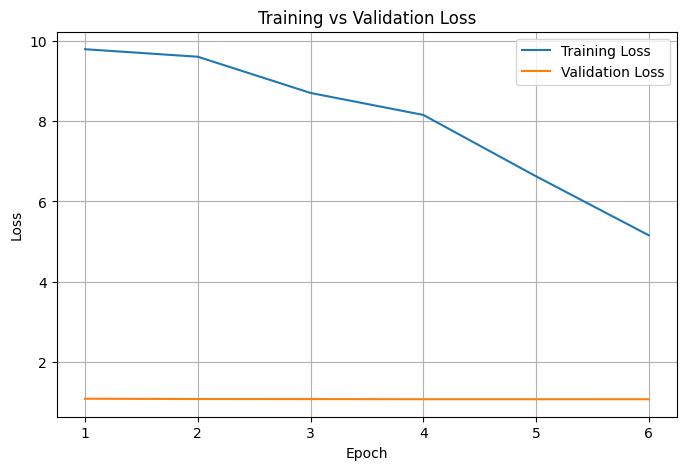

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
val_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Epochs (could mismatch if you logged more frequently)
epochs = range(1, len(val_loss) + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss[:len(val_loss)], label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Only test on the first 500 examples (adjust as needed)
small_test_dataset = test_dataset.select(range(500))
predicted_dataset = small_test_dataset.map(generate_summary, batched=True, batch_size=8)


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
# Compute ROUGE scores
results = rouge.compute(
    predictions=predicted_dataset["predicted_summary"],
    references=predicted_dataset["highlights"]  # Or "summary", depending on your column name
)

# Display scores
for key in results:
    print(f"{key}: {results[key]:.4f}")


rouge1: 0.3604
rouge2: 0.1588
rougeL: 0.2500
rougeLsum: 0.3121


In [ ]:
for i in range(5):
    print("ARTICLE:\n", predicted_dataset[i]["article"])
    print("REFERENCE SUMMARY:\n", predicted_dataset[i]["highlights"])  # or "summary"
    print("PREDICTED SUMMARY:\n", predicted_dataset[i]["predicted_summary"])
    print("-" * 80)


ARTICLE:
 By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly 

In [ ]:
!pip install bert_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [ ]:
bertscore = evaluate.load("bertscore")

bertscore_result = bertscore.compute(
    predictions=predicted_dataset["predicted_summary"],
    references=predicted_dataset["highlights"],
    lang="en"
)

print(f"BERTScore - Precision: {sum(bertscore_result['precision'])/len(bertscore_result['precision']):.4f}")
print(f"BERTScore - Recall: {sum(bertscore_result['recall'])/len(bertscore_result['recall']):.4f}")
print(f"BERTScore - F1: {sum(bertscore_result['f1'])/len(bertscore_result['f1']):.4f}")


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore - Precision: 0.8680
BERTScore - Recall: 0.8683
BERTScore - F1: 0.8680
